In [179]:
import numpy as np
import matplotlib.pyplot as plt

PDE:
$$
u_t=u_{xx},\quad0\le x\le2\pi
$$
Boundary Conditions:
$$
u(0,t)=u(2\pi,t)=0
$$
Initial Condition:
$$
u(x,0)=\sin(mx)
$$

In [180]:
def tridiagonal_solver(A,b):
    N=A.shape[0]
    assert A.shape[1]==N
    assert b.shape[0]==N

    

In [ ]:
from re import I


def forward_euler(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    for n in range(u.shape[1]-1): #time
        for j in range(1,u.shape[2]-1): #space
            u[:,n+1,j]=r*(u[:,n,j+1]-2*u[:,n,j]+u[:,n,j-1])+u[:,n,j]
    return u,grid

In [ ]:
def backward_euler(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    
    A=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(A,1+2*r)
    np.fill_diagonal(A[1:],-r)
    np.fill_diagonal(A[:,1:],-r)
    
    for n in range(u.shape[1]-1): #time
        b=u[:,n,1:-1].T
        u[:,n+1,1:-1]=np.linalg.solve(A,b).T
    return u,grid

In [ ]:
def crank_nicolson(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    
    A=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(A,2+2*r)
    np.fill_diagonal(A[1:],-r)
    np.fill_diagonal(A[:,1:],-r)
    
    B=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(B,2-2*r)
    np.fill_diagonal(B[1:],r)
    np.fill_diagonal(B[:,1:],r)
    
    for n in range(u.shape[1]-1): #time
        b=B @ u[:,n,1:-1].T
        u[:,n+1,1:-1]=np.linalg.solve(A,b).T
    return u,grid

(2, 62, 21)


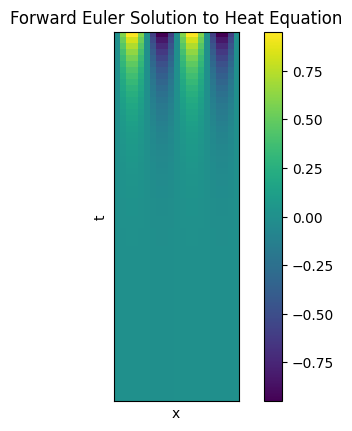

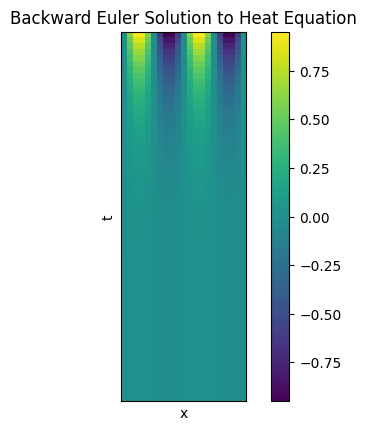

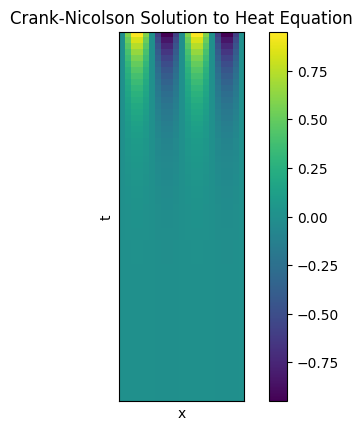

In [184]:
fe_solution,grid=forward_euler(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
be_solution,grid=backward_euler(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
cn_solution,grid=crank_nicolson(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
print(grid.shape)
plt.imshow(fe_solution.squeeze())
plt.colorbar()
plt.title('Forward Euler Solution to Heat Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(be_solution.squeeze())
plt.colorbar()
plt.title('Backward Euler Solution to Heat Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(cn_solution.squeeze())
plt.colorbar()
plt.title('Crank-Nicolson Solution to Heat Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.xticks([])
plt.yticks([])
plt.show()

In [185]:
def exact_solution(grid,m):
    u=np.zeros((1,grid.shape[1],grid.shape[2]))
    for i in range(u.shape[1]):
        u[:,i,:]=np.exp(-m**2 * grid[1,i]) * np.sin(m * grid[0,i])
    return u

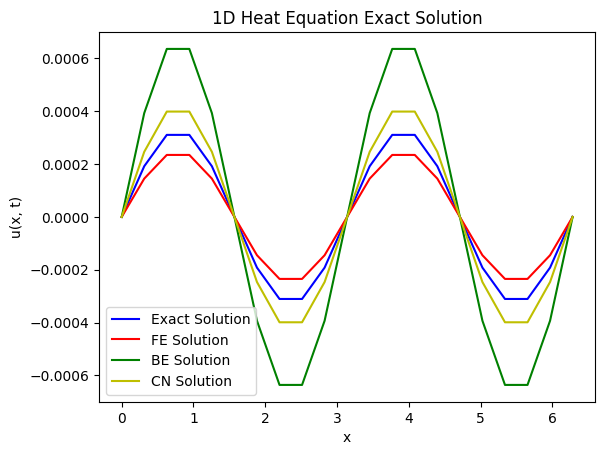

In [186]:
solution = exact_solution(grid, 2)
plt.plot(grid[0,-1], solution[0,-1], label='Exact Solution',c='b')
plt.plot(grid[0,-1], fe_solution[0,-1], label='FE Solution',c='r')
plt.plot(grid[0,-1], be_solution[0,-1], label='BE Solution',c='g')
plt.plot(grid[0,-1], cn_solution[0,-1], label='CN Solution',c='y')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('1D Heat Equation Exact Solution')
plt.legend(loc='lower left')
plt.show()